In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

%matplotlib inline

pd.set_option('display.max_columns', None)

# Business Questions

Some of the questions that come to mind based on the data available in Kaggle, are as follows:

- Have the rent distributions or averages changed over the year?
- Are there certain dates where occupation spikes?
- How do rent trends compare across both states?
- How do different property and room types compare to each other?
- Are there certain factors that could affect the rent prices in each location?

Ultimately the post wants to provide information regarding the best places to invest on for-rental properties.

# Data wrangling

First we open each of the files for both Boston and Seattle, and we need to determine the file structure and if both files is the same, or we need to drop certain columns

In [2]:
boston_calendar = pd.read_csv('Boston/calendar.csv')
boston_listings = pd.read_csv('Boston/listings.csv')
boston_reviews = pd.read_csv('Boston/reviews.csv')

In [3]:
seattle_calendar = pd.read_csv('Seattle/calendar.csv')
seattle_listings = pd.read_csv('Seattle/listings.csv')
seattle_reviews = pd.read_csv('Seattle/reviews.csv')

## File structures

There seems to be a discrepancy in the number of columns in both files based on the shape values, so we need to analyze what kind of data those columns have.  Currently these are 92 vs. 95, so we'll find the columns programatically

In [4]:
seattle_listings.shape, boston_listings.shape

((3818, 92), (3585, 95))

In [5]:
missing_cols = []

for col in boston_listings.columns:
    if col not in seattle_listings.columns:
        print(f'{col} column from Boston, missing in Seattle listings')
        missing_cols.append(col)

access column from Boston, missing in Seattle listings
interaction column from Boston, missing in Seattle listings
house_rules column from Boston, missing in Seattle listings


In [6]:
boston_listings[missing_cols].head()

,access,interaction,house_rules
0,"You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...
1,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...
2,"I am living in the apartment during your stay,...","ABOUT ME: I'm a laid-back, friendly, unmarried...","I encourage you to use my kitchen, cooking and..."
3,The basement has a washer dryer and gym area. ...,We do live in the house therefore might be som...,- The bathroom and house are shared so please ...
4,You will have access to the front and side por...,I love my city and really enjoy sharing it wit...,"Please no smoking in the house, porch or on th..."


Now, if were to drop some of the columns in listings, we should also see if columns match the structure after removing, which they do:

In [7]:
(seattle_listings.columns == (boston_listings.drop(missing_cols,axis=1).columns))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

## Listings

By looking at the listings files, we can notice right away there are a number of text fields that for this analysis we most likely won't be using, so we can set them up on an array of values to later delete programatically

In [8]:
drop_columns = ['listing_url','name','summary','space','description','neighborhood_overview','notes','transit','thumbnail_url','medium_url','picture_url','xl_picture_url','host_url','host_about','host_thumbnail_url','host_picture_url','latitude','longitude','calendar_updated','neighbourhood_cleansed','neighbourhood_group_cleansed']

In [9]:
boston_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

In [10]:
seattle_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

## Reviews 

Both review files seem to be very basic, without a rating, just test and review IDs plus reviewerIDs ... we might be able to use this to count the reviews and relate to the dates at least

In [11]:
boston_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [12]:
seattle_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


## Calendars

We have the date and availability = t for used listings with the corresponding price.  When a listing is not used is makred as availability = f and a NaN value for price

In [13]:
seattle_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [14]:
boston_calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


## Cleanup

### Listings

We will remove the columns found on the previous sections, and verify the data types:

In [15]:
boston_listings_clean = boston_listings.drop(missing_cols, axis=1)
boston_listings_clean = boston_listings_clean.drop(drop_columns, axis=1)
seattle_listings_clean = seattle_listings.drop(drop_columns, axis=1)

In [16]:
boston_listings_clean.columns == seattle_listings_clean.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [17]:
for cols in boston_listings_clean.columns:
    if boston_listings_clean[col].dtype != seattle_listings_clean[col].dtype:
        print(f'Different dtypes in {col}')
print('All done.')

All done.


We will now check for certain columns that may have single values in a column to determine if we can drop some more to compact the data further.  There may be some repeating and/or useless data still.

In [18]:
for column in boston_listings_clean.columns:
    print(f'***\n{column}:')
    print(f'* Boston: {boston_listings_clean[column].nunique()}: \n{boston_listings_clean[column].unique()}')
    print(f'* Seattle: {seattle_listings_clean[column].nunique()}: \n{seattle_listings_clean[column].unique()}')


***
id:
* Boston: 3585: 
[12147973  3075044     6976 ... 14585486 14603878 14504422]
* Seattle: 3818: 
[  241032   953595  3308979 ... 10267360  9604740 10208623]
***
scrape_id:
* Boston: 1: 
[20160906204935]
* Seattle: 1: 
[20160104002432]
***
last_scraped:
* Boston: 1: 
['2016-09-07']
* Seattle: 1: 
['2016-01-04']
***
experiences_offered:
* Boston: 1: 
['none']
* Seattle: 1: 
['none']
***
host_id:
* Boston: 2181: 
[31303940  2572247    16701 ... 67981314 11311919 74318064]
* Seattle: 2751: 
[  956883  5177328 16708587 ... 52791370 25522052 14703116]
***
host_name:
* Boston: 1334: 
['Virginia' 'Andrea' 'Phil' ... 'Sofia And Kim' 'Gillian' 'Medi']
* Seattle: 1466: 
['Maija' 'Andrea' 'Jill' ... 'Flora' 'Eve' 'Virginia']
***
host_since:
* Boston: 1281: 
['2015-04-15' '2012-06-07' '2009-05-11' ... '2014-09-09' '2015-12-04'
 '2016-05-27']
* Seattle: 1380: 
['2011-08-11' '2013-02-21' '2014-06-12' ... '2011-03-27' '2015-12-30'
 '2014-04-25']
***
host_location:
* Boston: 176: 
['Boston, Massa

In [19]:
additional_remove_columns = ['scrape_id','last_scraped','experiences_offered','host_name','host_since','host_location','host_neighbourhood','host_has_profile_pic','street','neighbourhood','market','smart_location','country_code','country','is_location_exact','has_availability','calendar_last_scraped','first_review','last_review','requires_license','license','jurisdiction_names']
boston_listings_clean = boston_listings_clean.drop(additional_remove_columns, axis=1)
seattle_listings_clean = seattle_listings_clean.drop(additional_remove_columns, axis=1)
boston_listings_clean.columns == seattle_listings_clean.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [20]:
for column in boston_listings_clean.columns:
    print(f'***\n{column}:')
    print(f'* Boston: {boston_listings_clean[column].nunique()}: \n{boston_listings_clean[column].unique()}')
    print(f'* Seattle: {seattle_listings_clean[column].nunique()}: \n{seattle_listings_clean[column].unique()}')


***
id:
* Boston: 3585: 
[12147973  3075044     6976 ... 14585486 14603878 14504422]
* Seattle: 3818: 
[  241032   953595  3308979 ... 10267360  9604740 10208623]
***
host_id:
* Boston: 2181: 
[31303940  2572247    16701 ... 67981314 11311919 74318064]
* Seattle: 2751: 
[  956883  5177328 16708587 ... 52791370 25522052 14703116]
***
host_response_time:
* Boston: 4: 
[nan 'within an hour' 'within a few hours' 'within a day'
 'a few days or more']
* Seattle: 4: 
['within a few hours' 'within an hour' nan 'within a day'
 'a few days or more']
***
host_response_rate:
* Boston: 52: 
[nan '100%' '98%' '83%' '75%' '60%' '95%' '77%' '90%' '50%' '93%' '70%'
 '71%' '36%' '73%' '67%' '33%' '78%' '86%' '80%' '96%' '40%' '0%' '94%'
 '92%' '97%' '89%' '88%' '31%' '91%' '81%' '99%' '85%' '69%' '56%' '30%'
 '68%' '82%' '17%' '14%' '38%' '63%' '43%' '64%' '19%' '79%' '61%' '57%'
 '84%' '25%' '20%' '6%' '10%']
* Seattle: 45: 
['96%' '98%' '67%' nan '100%' '71%' '97%' '60%' '50%' '31%' '90%' '70%'
 '88%'

 'Phinney Ridge Seattle' 'seattle']
***
state:
* Boston: 1: 
['MA']
* Seattle: 2: 
['WA' 'wa']
***
zipcode:
* Boston: 43: 
['02131' nan '02130' '02119' '02120' '02115' '02215' '02116' '02111'
 '02109' '02113' '02110' '02114' '02108' '02121' '02118' '02125' '02124'
 '02210' '02218' '02142' '02128' '02129' '02145' '02126' '02108 02111'
 '02472' '02122' '02446' '02135' '02134' '02445' '02132' '02467' '02136'
 '02186' '02169' '02127' '02134-1704' '02163' '02138' '02139' '02141'
 '02143']
* Seattle: 28: 
['98119' '98109' '98107' '98117' nan '98103' '98105' '98115' '98101'
 '98122' '98112' '98144' '99\n98122' '98121' '98102' '98199' '98104'
 '98134' '98136' '98126' '98146' '98116' '98177' '98118' '98108' '98133'
 '98106' '98178' '98125']
***
property_type:
* Boston: 13: 
['House' 'Apartment' 'Condominium' 'Villa' 'Bed & Breakfast' 'Townhouse'
 'Entire Floor' 'Loft' 'Guesthouse' 'Boat' 'Dorm' 'Other' nan 'Camper/RV']
* Seattle: 16: 
['Apartment' 'House' 'Cabin' 'Condominium' 'Camper/RV' 'Bung

#### Numeric

The following fields have to be converted to float or integer:
- price
- weekly_price
- monthly_price
- security_deposit
- cleaning_fee
- extra_people

In [21]:
columns_float = ['price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people']
for col in columns_float:
    print('Converting {}'.format(col))
    boston_listings_clean[col] = boston_listings_clean[col].apply(lambda x: float(x[1:].replace(',','')) if x==x else np.nan)
    seattle_listings_clean[col] = seattle_listings_clean[col].apply(lambda x: float(x[1:].replace(',','')) if x==x else np.nan)

Converting price
Converting weekly_price
Converting monthly_price
Converting security_deposit
Converting cleaning_fee
Converting extra_people


#### Rates

The following fields have to be converted to the 0-1 range without %:
- host_response_rate
- host_accceptance_rate

In [22]:
columns_perc = ['host_response_rate','host_acceptance_rate']
for col in columns_perc:
    print('Converting {}'.format(col))
    boston_listings_clean[col] = boston_listings_clean[col].apply(lambda x: float(x[:-1].replace(',',''))/100 if x==x else np.nan)
    seattle_listings_clean[col] = seattle_listings_clean[col].apply(lambda x: float(x[:-1].replace(',',''))/100 if x==x else np.nan)

Converting host_response_rate
Converting host_acceptance_rate


#### Boolean

These columns have to be converted to 0/1, as they are True-False or t-f:
- host_is_superhost
- host_identity_verified
- instant_bookable
- require_guest_profile_picture
- require_guest_phone_verification

In [23]:
columns_boolean = ['host_is_superhost','host_identity_verified','instant_bookable','require_guest_profile_picture','require_guest_phone_verification']
for col in columns_boolean:
    print('Converting {}'.format(col))
    boston_listings_clean[col] = boston_listings_clean[col].replace({'t':1,'f':0})
    seattle_listings_clean[col] = seattle_listings_clean[col].replace({'t':1,'f':0})

Converting host_is_superhost
Converting host_identity_verified
Converting instant_bookable
Converting require_guest_profile_picture
Converting require_guest_phone_verification


#### To be cleaned

These columns require additional cleansing given the series of values they contain:
- city
- state
- zipcode

In [24]:
columns_to_clean = ['city','state','zipcode']

for col in columns_to_clean:
    print('*'*30)
    print('Seattle {}, {}: {}'.format(col,seattle_listings_clean[col].nunique(), seattle_listings_clean[col].unique()))
    print('Boston {}, {}: {}'.format(col,boston_listings_clean[col].nunique(), boston_listings_clean[col].unique()))

******************************
Seattle city, 7: ['Seattle' 'Ballard, Seattle' 'West Seattle' 'Seattle ' '西雅图'
 'Phinney Ridge Seattle' 'seattle']
Boston city, 38: ['Boston' 'Roslindale' 'Roslindale, Boston' 'Jamaica Plain' 'Brookline'
 'Jamaica Plain, Boston' 'Jamaica Plain (Boston)' 'Roxbury Crossing'
 'Jamaica Plain ' 'Jamaica Plain, MA' 'Boston (Jamaica Plain)'
 'Jamaica plain ' 'ROXBURY CROSSING' 'Mission Hill, Boston' 'boston' '波士顿'
 'Boston, Massachusetts, US' 'South End, Boston' 'Cambridge' 'East Boston'
 'east Boston ' 'Charlestown' 'Boston (Charlestown)' 'Somerville'
 'Watertown' 'Brighton' 'Brighton ' 'Boston ' nan 'West Roxbury' 'Newton'
 'Hyde Park' 'Mattapan' 'Milton' 'Dorchester' 'dorchester, boston '
 'South Boston' 'Allston' 'ALLSTON']
******************************
Seattle state, 2: ['WA' 'wa']
Boston state, 1: ['MA']
******************************
Seattle zipcode, 28: ['98119' '98109' '98107' '98117' nan '98103' '98105' '98115' '98101'
 '98122' '98112' '98144' '99\n98

In [25]:
seattle_listings_clean['zipcode'] = seattle_listings_clean['zipcode'].apply(lambda x: x[-5:] if type(x) is str else x)
boston_listings_clean['zipcode'] = boston_listings_clean['zipcode'].apply(lambda x: x[:5] if type(x) is str else x)

In [26]:
seattle_listings_clean['state'] = seattle_listings_clean['state'].apply(lambda x: x.upper() if type(x) is str else x)

In [27]:
seattle_listings_clean['city'] = seattle_listings_clean['city'].apply(lambda x: x.strip().title().split(sep=',')[0] if type(x) is str else x)
boston_listings_clean['city'] = boston_listings_clean['city'].apply(lambda x: x.strip().title().split(sep=',')[0] if type(x) is str else x)

In [28]:
boston_replace_dict = {'Jamaica Plain (Boston)':'Jamaica Plain', 'Boston (Jamaica Plain)':'Jamaica Plain', 'Boston (Charlestown)':'Charlestown','波士顿':'Boston'}
boston_listings_clean['city'] = boston_listings_clean['city'].replace(boston_replace_dict)

In [29]:
seattle_replace_dict = {'西雅图':'Seattle'}
seattle_listings_clean['city'] = seattle_listings_clean['city'].replace(seattle_replace_dict)

In [30]:
for col in columns_to_clean:
    print('*'*30)
    print('Seattle {}, {}: {}'.format(col,seattle_listings_clean[col].nunique(), seattle_listings_clean[col].unique()))
    print('Boston {}, {}: {}'.format(col,boston_listings_clean[col].nunique(), boston_listings_clean[col].unique()))

******************************
Seattle city, 4: ['Seattle' 'Ballard' 'West Seattle' 'Phinney Ridge Seattle']
Boston city, 21: ['Boston' 'Roslindale' 'Jamaica Plain' 'Brookline' 'Roxbury Crossing'
 'Mission Hill' 'South End' 'Cambridge' 'East Boston' 'Charlestown'
 'Somerville' 'Watertown' 'Brighton' nan 'West Roxbury' 'Newton'
 'Hyde Park' 'Mattapan' 'Milton' 'Dorchester' 'South Boston' 'Allston']
******************************
Seattle state, 1: ['WA']
Boston state, 1: ['MA']
******************************
Seattle zipcode, 27: ['98119' '98109' '98107' '98117' nan '98103' '98105' '98115' '98101'
 '98122' '98112' '98144' '98121' '98102' '98199' '98104' '98134' '98136'
 '98126' '98146' '98116' '98177' '98118' '98108' '98133' '98106' '98178'
 '98125']
Boston zipcode, 41: ['02131' nan '02130' '02119' '02120' '02115' '02215' '02116' '02111'
 '02109' '02113' '02110' '02114' '02108' '02121' '02118' '02125' '02124'
 '02210' '02218' '02142' '02128' '02129' '02145' '02126' '02472' '02122'
 '02446

#### Numeric to be normalized

These columns should be normalized to 0-1, to represent a percentage of availability or max/min scores in each of the ranges:
- availability_30
- availability_60
- availability_90
- availability_365
- review_scores_rating
- review_scores_accuracy
- review_scores_cleanliness
- review_scores_checkin
- review_scores_communication
- review_scores_location
- review_scores_value
- minimum_nights
- maximum_nights

This will be done with a StandardScaler

#### Categorical

The following are categorical values to be converted via dummy variables.  For these as well as the ones with single values in a column, we'll do it once both sets have been merged:

- host_response_time
- property_type
- room_type
- bed_type
- cancellation_policy
- city
- state
- zipcode

In [31]:
all_listings = pd.concat([seattle_listings_clean, boston_listings_clean],axis=0).reset_index(drop=True)

In [32]:
all_listings.head()

,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,city,state,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,956883,within a few hours,0.96,1.0,0.0,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",1.0,Seattle,WA,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,85.0,NaN,NaN,NaN,NaN,2,5.0,1,365,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,moderate,0,0,2,4.07
1,953595,5177328,within an hour,0.98,1.0,1.0,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",1.0,Seattle,WA,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,150.0,1000.0,3000.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,1,1,6,1.48
2,3308979,16708587,within a few hours,0.67,1.0,0.0,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",1.0,Seattle,WA,98119,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,975.0,NaN,NaN,1000.0,300.0,10,25.0,4,30,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,0,0,2,1.15
3,7421966,9851441,NaN,NaN,NaN,0.0,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",1.0,Seattle,WA,98119,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",NaN,100.0,650.0,2300.0,NaN,NaN,1,0.0,1,1125,0,0,0,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,flexible,0,0,1,NaN
4,278830,1452570,within an hour,1.00,NaN,0.0,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1.0,Seattle,WA,98119,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,450.0,NaN,NaN,700.0,125.0,6,15.0,1,1125,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0,strict,0,0,1,0.89


In [33]:
columns_categorical = []
columns_room_types = ['property_type']
columns_location = ['city','state']

all_listings_clean = all_listings.copy()

def encode_categorical(df, columns):
    for col in columns:
        print('Processing {}...'.format(col))
        col_dummies = pd.get_dummies(df[col],prefix=col,prefix_sep='_')
        df = pd.concat([df,col_dummies],axis=1)
        df = df.drop(col,axis=1)

    df = df.reset_index(drop=True)
    
    return df

def delete_categorical(df, columns):
    return df.drop(columns,axis=1)

#all_listings_clean = encode_categorial(all_listings_clean)

#### Categorical with lists in a single column

These columns are categorical and have to be converted to columns based on the items on each list:
- amenities
- host_verifications


In [34]:
columns_explode = ['amenities']

def encode_explosions(df, columns):
    for col in columns:
        print('Processing {}...'.format(col))
        df1 = df[['id',col]]
        x = pd.get_dummies(df1[col].apply(lambda x: x[1:-1].replace('"','').replace('\'','').replace(' ','').split(sep=',')).explode(),prefix=col,prefix_sep='_')
        x = x.reset_index()
        x = pd.concat([df1,x.groupby('index').sum()],axis=1).drop([col,col+'_','id'],axis=1)
        df = pd.concat([df.drop(col,axis=1),x],axis=1)
        
    return df

In [35]:
all_listings_clean

,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,city,state,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,956883,within a few hours,0.96,1.00,0.0,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",1.0,Seattle,WA,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,85.0,NaN,NaN,NaN,NaN,2,5.0,1,365,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,moderate,0,0,2,4.07
1,953595,5177328,within an hour,0.98,1.00,1.0,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",1.0,Seattle,WA,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,150.0,1000.0,3000.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,1,1,6,1.48
2,3308979,16708587,within a few hours,0.67,1.00,0.0,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",1.0,Seattle,WA,98119,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,975.0,NaN,NaN,1000.0,300.0,10,25.0,4,30,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,0,0,2,1.15
3,7421966,9851441,NaN,NaN,NaN,0.0,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",1.0,Seattle,WA,98119,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",NaN,100.0,650.0,2300.0,NaN,NaN,1,0.0,1,1125,0,0,0,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,flexible,0,0,1,NaN
4,278830,1452570,within an hour,1.00,NaN,0.0,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1.0,Seattle,WA,98119,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,450.0,NaN,NaN,700.0,125.0,6,15.0,1,1125,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0,strict,0,0,1,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7398,8373729,19246369,within an hour,0.96,1.00,0.0,28.0,28.0,"['email', 'phone', 'reviews', 'jumio']",1.0,Somerville,MA,02143,Apartment,Private room,3,1.0,1.0,1.0,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",NaN,69.0,NaN,NaN,95.0,NaN,1,24.0,2,1125,21,51,81,356,4,90.0,10.0,10.0,10.0,10.0,8.0,9.0,1,strict,0,0,8,0.34
7399,14844274,37366454,a few days or more,0.10,0.83,0.0,2.0,2.0,"['email', 'phone', 'reviews', 'weibo', 'jumio']",1.0,Brookline,MA,02446,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,150.0,NaN,NaN,100.0,15.0,1,0.0,3,365,29,59,89,364,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,strict,0,0,2,NaN
7400,14585486,11311919,within a day,0.78,0.50,0.0,1.0,1.0,['phone'],0.0,Cambridge,MA,02141,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{""translation missing: en.hosting_amenity_49"",...",NaN,198.0,NaN,NaN,NaN,NaN,1,0.0,3,12,0,15,40,40,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,flexible,0,0,1,NaN
7401,14603878,74318064,within an hour,1.00,0.96,0.0,4.0,4.0,"['email', 'phone', 'google', 'reviews', 'jumio']",1.0,Somerville,MA,02145,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Kitchen,Gym,""Family/Kid Friendly"",Washer,Drye...",NaN,65.0,NaN,NaN,100.0,NaN,1,30.0,1,13,5,5,5,253,2,90.0,9.0,8.0,9.0,9.0,8.0,7.0,0,strict,0,0,1,2.00


In [36]:
(all_listings_clean['id'] == all_listings['id']).sum()

7403

At this point, we've cleaned up the data and converted all categorical variables to one-hot encoded columns, so we'll add into this data frame an average rent value for each property over the year

### Calendars

We can use the calendar data to calculate the occupancy rate for each of the listings, as well as determining the average occupancy and 

In [37]:
all_calendars = pd.concat([boston_calendar,seattle_calendar],axis=0)
all_calendars

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN
...,...,...,...,...
1393565,10208623,2016-12-29,f,NaN
1393566,10208623,2016-12-30,f,NaN
1393567,10208623,2016-12-31,f,NaN
1393568,10208623,2017-01-01,f,NaN


In [38]:
replace_booleans = {'t':1,'f':0} 
all_calendars['price'] = all_calendars['price'].apply(lambda x: float(x[1:].replace(',','')) if x==x else np.nan)
all_calendars['year_month'] = all_calendars['date'].apply(lambda x: int(x[5:7]))
all_calendars['available'] = all_calendars['available'].replace(replace_booleans)

In [39]:
#This will determine how many days of the year a listing is occupied over the year
availability = all_calendars.groupby('listing_id').mean()
availability = availability.drop(['price','year_month'],axis=1)

In [40]:
availability = availability.reset_index()
availability

,listing_id,available
0,3335,0.846575
1,3353,0.682192
2,4291,1.000000
3,5506,0.942466
4,5682,0.846575
...,...,...
7398,14924831,0.180822
7399,14928000,1.000000
7400,14928333,0.928767
7401,14933380,0.221918


In [41]:
listing_location = all_listings[['id','state']]
listing_location = listing_location

In [42]:
all_calendars = all_calendars.merge(listing_location, how='left', left_on='listing_id', right_on='id')

In [43]:
all_calendars

,listing_id,date,available,price,year_month,id,state
0,12147973,2017-09-05,0,NaN,9,12147973,MA
1,12147973,2017-09-04,0,NaN,9,12147973,MA
2,12147973,2017-09-03,0,NaN,9,12147973,MA
3,12147973,2017-09-02,0,NaN,9,12147973,MA
4,12147973,2017-09-01,0,NaN,9,12147973,MA
...,...,...,...,...,...,...,...
2702455,10208623,2016-12-29,0,NaN,12,10208623,WA
2702456,10208623,2016-12-30,0,NaN,12,10208623,WA
2702457,10208623,2016-12-31,0,NaN,12,10208623,WA
2702458,10208623,2017-01-01,0,NaN,1,10208623,WA


In [44]:
all_calendars.groupby('state').max(),all_calendars.groupby('state').min()

(       listing_id        date  available   price  year_month        id
 state                                                                 
 MA       14933461  2017-09-05          1  7163.0          12  14933461
 WA       10340165  2017-01-02          1  1650.0          12  10340165,
        listing_id        date  available  price  year_month    id
 state                                                            
 MA           3353  2016-09-06          0   11.0           1  3353
 WA           3335  2016-01-04          0   10.0           1  3335)

In [45]:
monthly_summary = all_calendars.groupby(['year_month','state'],as_index=False).mean().drop(['listing_id','id'],axis=1)
monthly_summary = monthly_summary.replace({'WA':'Seattle', 'MA':'Boston'})
monthly_summary_wa = monthly_summary.query('state == "Seattle"').reset_index(drop=True)
monthly_summary_ma = monthly_summary.query('state == "Boston"').reset_index(drop=True)

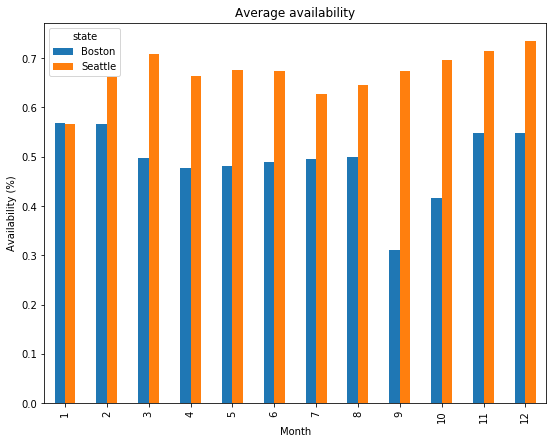

In [83]:
monthly_summary.pivot(index='year_month',values='available',columns='state').plot(kind='bar',figsize=(9,7))
plt.title('Average availability')
plt.xlabel('Month')
plt.ylabel('Availability (%)')
plt.savefig('average_availability');

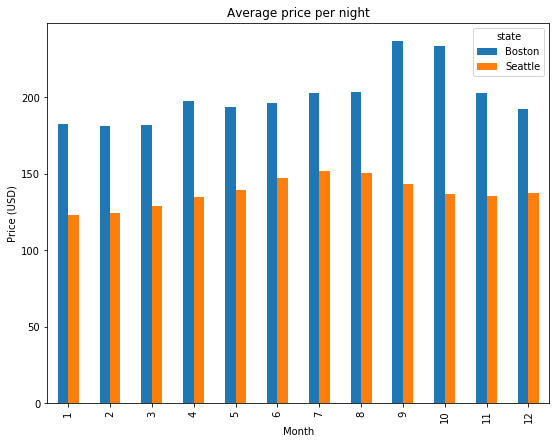

In [82]:
monthly_summary.pivot(index='year_month',values='price',columns='state').plot(kind='bar',figsize=(9,7))
plt.title('Average price per night')
plt.xlabel('Month')
plt.ylabel('Price (USD)')
plt.savefig('average_price');

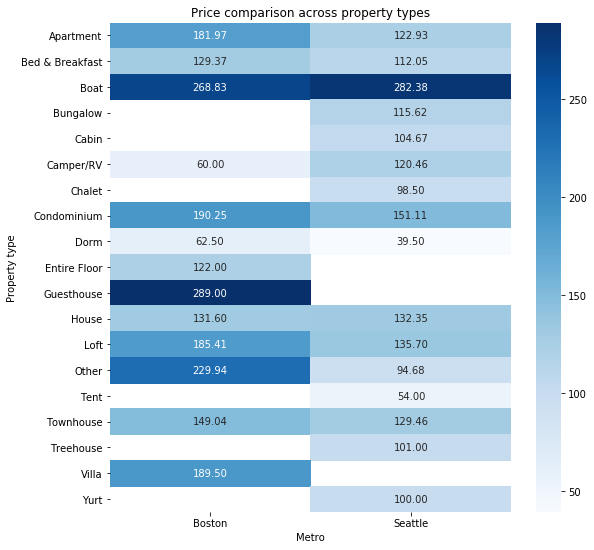

In [48]:
all_listings_by_type = all_listings.groupby(['state','property_type'],as_index=False).mean()[['state','property_type','price']]
all_listings_by_type['state'] = all_listings_by_type['state'].replace({'WA':'Seattle', 'MA':'Boston'})
plt.figure(figsize=(9,9))
sns.heatmap(all_listings_by_type.pivot(index='property_type',values='price',columns='state'),cmap='Blues',annot=True,fmt='.2f')
plt.title('Price comparison across property types')
plt.ylabel('Property type')
plt.xlabel('Metro')
plt.savefig('property_types_heatmap');

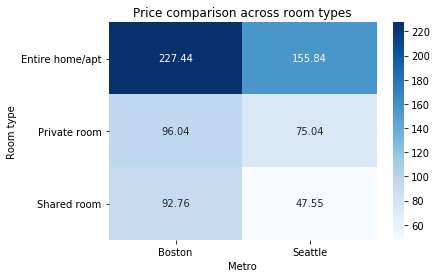

In [49]:
all_listings_by_type = all_listings.groupby(['state','room_type'],as_index=False).mean()[['state','room_type','price']]
all_listings_by_type['state'] = all_listings_by_type['state'].replace({'WA':'Seattle', 'MA':'Boston'})
sns.heatmap(all_listings_by_type.pivot(index='room_type',values='price',columns='state'),cmap='Blues',annot=True,fmt='.2f')
plt.title('Price comparison across room types')
plt.ylabel('Room type')
plt.xlabel('Metro')
plt.savefig('room_type_heatmap');

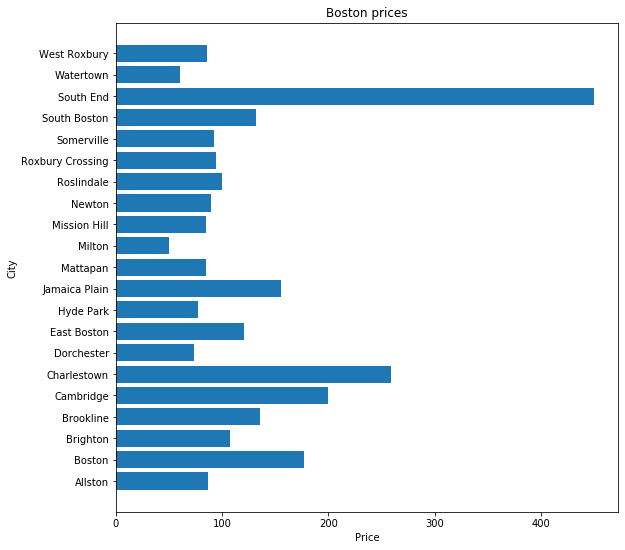

In [79]:
all_listings_by_city = all_listings.groupby(['state','city'],as_index=False).mean()[['state','city','price']]
all_listings_sea = all_listings_by_city.query('state == "WA"')
all_listings_bos = all_listings_by_city.query('state == "MA"')

plt.figure(figsize=(9,9))
plt.barh(data=all_listings_bos, y='city',width='price')
plt.title('Boston prices')
plt.ylabel('City')
plt.xlabel('Price')
plt.savefig('boston_prices');

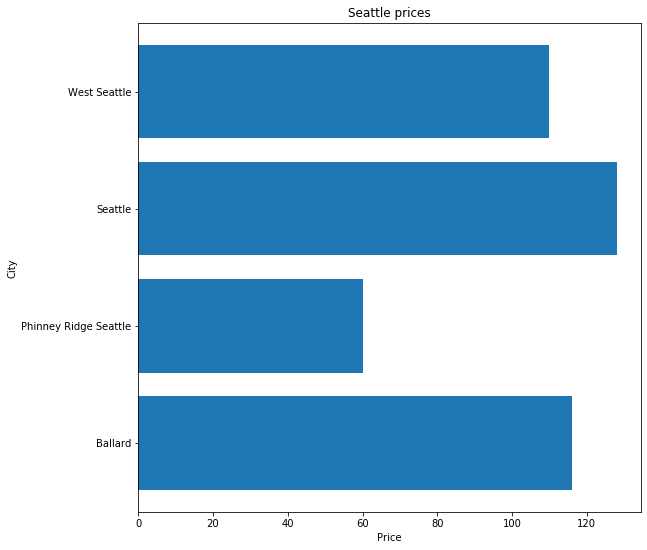

In [80]:
plt.figure(figsize=(9,9))
plt.barh(data=all_listings_sea, y='city',width='price')
plt.title('Seattle prices')
plt.ylabel('City')
plt.xlabel('Price')

plt.savefig('seattle_prices')

## Matching the occupancy and listing data

We'll use a couple of models to look at factors that improve price and occupancy of a listing, so we'll need to incorporate the occupancy data we calculated into the main set for later use of it.

In [51]:
all_listings_clean

,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,city,state,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,956883,within a few hours,0.96,1.00,0.0,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",1.0,Seattle,WA,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,85.0,NaN,NaN,NaN,NaN,2,5.0,1,365,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,moderate,0,0,2,4.07
1,953595,5177328,within an hour,0.98,1.00,1.0,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",1.0,Seattle,WA,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,150.0,1000.0,3000.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,1,1,6,1.48
2,3308979,16708587,within a few hours,0.67,1.00,0.0,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",1.0,Seattle,WA,98119,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,975.0,NaN,NaN,1000.0,300.0,10,25.0,4,30,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,0,0,2,1.15
3,7421966,9851441,NaN,NaN,NaN,0.0,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",1.0,Seattle,WA,98119,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",NaN,100.0,650.0,2300.0,NaN,NaN,1,0.0,1,1125,0,0,0,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,flexible,0,0,1,NaN
4,278830,1452570,within an hour,1.00,NaN,0.0,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1.0,Seattle,WA,98119,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,450.0,NaN,NaN,700.0,125.0,6,15.0,1,1125,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0,strict,0,0,1,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7398,8373729,19246369,within an hour,0.96,1.00,0.0,28.0,28.0,"['email', 'phone', 'reviews', 'jumio']",1.0,Somerville,MA,02143,Apartment,Private room,3,1.0,1.0,1.0,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",NaN,69.0,NaN,NaN,95.0,NaN,1,24.0,2,1125,21,51,81,356,4,90.0,10.0,10.0,10.0,10.0,8.0,9.0,1,strict,0,0,8,0.34
7399,14844274,37366454,a few days or more,0.10,0.83,0.0,2.0,2.0,"['email', 'phone', 'reviews', 'weibo', 'jumio']",1.0,Brookline,MA,02446,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,150.0,NaN,NaN,100.0,15.0,1,0.0,3,365,29,59,89,364,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,strict,0,0,2,NaN
7400,14585486,11311919,within a day,0.78,0.50,0.0,1.0,1.0,['phone'],0.0,Cambridge,MA,02141,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{""translation missing: en.hosting_amenity_49"",...",NaN,198.0,NaN,NaN,NaN,NaN,1,0.0,3,12,0,15,40,40,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,flexible,0,0,1,NaN
7401,14603878,74318064,within an hour,1.00,0.96,0.0,4.0,4.0,"['email', 'phone', 'google', 'reviews', 'jumio']",1.0,Somerville,MA,02145,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Kitchen,Gym,""Family/Kid Friendly"",Washer,Drye...",NaN,65.0,NaN,NaN,100.0,NaN,1,30.0,1,13,5,5,5,253,2,90.0,9.0,8.0,9.0,9.0,8.0,7.0,0,strict,0,0,1,2.00


In [52]:
all_listings_complete = all_listings_clean.merge(availability, how='left', left_on='id', right_on='listing_id')
all_listings_complete = all_listings_complete.drop(['listing_id','host_id'],axis=1)
all_listings_complete

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,city,state,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,available
0,241032,within a few hours,0.96,1.00,0.0,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",1.0,Seattle,WA,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,85.0,NaN,NaN,NaN,NaN,2,5.0,1,365,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,moderate,0,0,2,4.07,0.947945
1,953595,within an hour,0.98,1.00,1.0,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",1.0,Seattle,WA,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,150.0,1000.0,3000.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,1,1,6,1.48,0.797260
2,3308979,within a few hours,0.67,1.00,0.0,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",1.0,Seattle,WA,98119,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,975.0,NaN,NaN,1000.0,300.0,10,25.0,4,30,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,0,0,2,1.15,0.602740
3,7421966,NaN,NaN,NaN,0.0,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",1.0,Seattle,WA,98119,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",NaN,100.0,650.0,2300.0,NaN,NaN,1,0.0,1,1125,0,0,0,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,flexible,0,0,1,NaN,0.391781
4,278830,within an hour,1.00,NaN,0.0,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1.0,Seattle,WA,98119,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,450.0,NaN,NaN,700.0,125.0,6,15.0,1,1125,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0,strict,0,0,1,0.89,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7398,8373729,within an hour,0.96,1.00,0.0,28.0,28.0,"['email', 'phone', 'reviews', 'jumio']",1.0,Somerville,MA,02143,Apartment,Private room,3,1.0,1.0,1.0,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",NaN,69.0,NaN,NaN,95.0,NaN,1,24.0,2,1125,21,51,81,356,4,90.0,10.0,10.0,10.0,10.0,8.0,9.0,1,strict,0,0,8,0.34,0.975342
7399,14844274,a few days or more,0.10,0.83,0.0,2.0,2.0,"['email', 'phone', 'reviews', 'weibo', 'jumio']",1.0,Brookline,MA,02446,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,150.0,NaN,NaN,100.0,15.0,1,0.0,3,365,29,59,89,364,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,strict,0,0,2,NaN,0.997260
7400,14585486,within a day,0.78,0.50,0.0,1.0,1.0,['phone'],0.0,Cambridge,MA,02141,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{""translation missing: en.hosting_amenity_49"",...",NaN,198.0,NaN,NaN,NaN,NaN,1,0.0,3,12,0,15,40,40,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,flexible,0,0,1,NaN,0.109589
7401,14603878,within an hour,1.00,0.96,0.0,4.0,4.0,"['email', 'phone', 'google', 'reviews', 'jumio']",1.0,Somerville,MA,02145,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Kitchen,Gym,""Family/Kid Friendly"",Washer,Drye...",NaN,65.0,NaN,NaN,100.0,NaN,1,30.0,1,13,5,5,5,253,2,90.0,9.0,8.0,9.0,9.0,8.0,7.0,0,strict,0,0,1,2.00,0.6

# Evaluating completeness of the final data

We will determine at this point if the data is all valid or we would like to drop or impute some of the values.

For our current analysis, we'll focus on the daily price as a target, so we will drop the other price columns.  We will also remove the additional costs per security deposit, cleaning fees and extra people costs to simplify the analysis.

In [53]:
all_listings_complete = all_listings_complete.drop(['monthly_price','weekly_price','security_deposit','cleaning_fee','guests_included','extra_people','cancellation_policy'],axis=1)
all_listings_complete.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,city,state,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,available
0,241032,within a few hours,0.96,1.0,0.0,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",1.0,Seattle,WA,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,85.0,1,365,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,0,0,2,4.07,0.947945
1,953595,within an hour,0.98,1.0,1.0,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",1.0,Seattle,WA,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,150.0,2,90,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,1,6,1.48,0.797260
2,3308979,within a few hours,0.67,1.0,0.0,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",1.0,Seattle,WA,98119,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,975.0,4,30,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,2,1.15,0.602740
3,7421966,NaN,NaN,NaN,0.0,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",1.0,Seattle,WA,98119,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",NaN,100.0,1,1125,0,0,0,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,NaN,0.391781
4,278830,within an hour,1.00,NaN,0.0,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1.0,Seattle,WA,98119,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,450.0,1,1125,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0,0,0,1,0.89,1.000000


In [54]:
total = 0
for col in all_listings_complete.columns:
    nulls = all_listings_complete[col].isnull().mean()
    if nulls != 0:
        print('{} is {:.2f}% complete'.format(col,(1-nulls)*100))
        total += 1 
print('Total {}'.format(total))

host_response_time is 86.57% complete
host_response_rate is 86.57% complete
host_acceptance_rate is 83.20% complete
host_is_superhost is 99.97% complete
host_listings_count is 99.97% complete
host_total_listings_count is 99.97% complete
host_identity_verified is 99.97% complete
city is 99.97% complete
zipcode is 99.39% complete
property_type is 99.95% complete
bathrooms is 99.59% complete
bedrooms is 99.78% complete
beds is 99.86% complete
square_feet is 2.07% complete
review_scores_rating is 80.28% complete
review_scores_accuracy is 79.99% complete
review_scores_cleanliness is 80.13% complete
review_scores_checkin is 80.04% complete
review_scores_communication is 80.16% complete
review_scores_location is 80.05% complete
review_scores_value is 80.05% complete
reviews_per_month is 81.32% complete
Total 22


Based on the above we will:

- Delete columns:
    - square_feet, since only 2% of the values are there, so it doesn't seem like a useful column
    - host_listings_count, seems redundant with other columns
- Impute with the mean:
    - all review scores seem like a good place to rate with the mean of the column
    - host_response_rate, host_acceptance_rate
- Delete rows:
    - when bathrooms, bedrooms or beds don't have values, it can be assumed that this data is not correct, so we will remove them, given that it's a very small number of records overall.
    - city, zipcode, property_type
- Impute with 0:
    - host_total_listings, host_identity_verified and host_is_superhost because we can assume the host has no listings, and identity has not been verified or the user is not a superhost (it's also a boolean).
    - reviews_per_month, as there most likely are none


In [55]:
delete_columns = ['host_listings_count','square_feet','zipcode','room_type','bed_type',
                  'host_verifications','host_acceptance_rate','host_response_time']
impute_mean = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
               'review_scores_checkin','review_scores_communication','review_scores_location',
               'review_scores_value','host_response_rate']
delete_rows = ['bathrooms','bedrooms','beds','city','property_type']
impute_zero = ['host_total_listings_count', 'host_identity_verified', 
               'host_is_superhost','reviews_per_month']

In [56]:
len(delete_columns+impute_mean+delete_rows+impute_zero)

25

In [57]:
#Delete columns
all_listings_complete = all_listings_complete.drop(delete_columns, axis=1)

In [58]:
#Impute with the mean
for col in impute_mean:
    print('Imputing {} ... '.format(col))
    all_listings_complete[col] = all_listings_complete[col].fillna(all_listings_complete[col].mean())

Imputing review_scores_rating ... 
Imputing review_scores_accuracy ... 
Imputing review_scores_cleanliness ... 
Imputing review_scores_checkin ... 
Imputing review_scores_communication ... 
Imputing review_scores_location ... 
Imputing review_scores_value ... 
Imputing host_response_rate ... 


In [59]:
#Delete empty rows for cette columns
for col in delete_rows:
    print('Deleteing rows for empty {} ... '.format(col))
    all_listings_complete = all_listings_complete.dropna(subset=[col])

Deleteing rows for empty bathrooms ... 
Deleteing rows for empty bedrooms ... 
Deleteing rows for empty beds ... 
Deleteing rows for empty city ... 
Deleteing rows for empty property_type ... 


In [60]:
#Impute with the mean
for col in impute_zero:
    print('Imputing {} ... '.format(col))
    all_listings_complete[col] = all_listings_complete[col].fillna(0)

Imputing host_total_listings_count ... 
Imputing host_identity_verified ... 
Imputing host_is_superhost ... 
Imputing reviews_per_month ... 


In [61]:
total = 0
for col in all_listings_complete.columns:
    nulls = all_listings_complete[col].isnull().mean()
    if nulls != 0:
        print('{} is {:.2f}% complete'.format(col,(1-nulls)*100))
        total += 1 
print('Total {}'.format(total))

Total 0


In [62]:
all_listings_complete.shape

(7347, 34)

In [63]:
all_listings_complete

,id,host_response_rate,host_is_superhost,host_total_listings_count,host_identity_verified,city,state,property_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,available
0,241032,0.960000,0.0,3.0,1.0,Seattle,WA,Apartment,4,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,1,365,14,41,71,346,207,95.000000,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,0,0,0,2,4.07,0.947945
1,953595,0.980000,1.0,6.0,1.0,Seattle,WA,Apartment,4,1.0,1.0,1.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,2,90,13,13,16,291,43,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0,1,1,6,1.48,0.797260
2,3308979,0.670000,0.0,2.0,1.0,Seattle,WA,House,11,4.5,5.0,7.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,4,30,1,6,17,220,20,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0,0,0,2,1.15,0.602740
3,7421966,0.949365,0.0,1.0,1.0,Seattle,WA,Apartment,3,1.0,0.0,2.0,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",100.0,1,1125,0,0,0,143,0,93.316002,9.540865,9.417229,9.721181,9.733569,9.518056,9.319777,0,0,0,1,0.00,0.391781
4,278830,1.000000,0.0,2.0,1.0,Seattle,WA,House,6,2.0,3.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0,1,1125,30,60,90,365,38,92.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0,0,0,1,0.89,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7398,8373729,0.960000,0.0,28.0,1.0,Somerville,MA,Apartment,3,1.0,1.0,1.0,"{Internet,""Wireless Internet"",""Air Conditionin...",69.0,2,1125,21,51,81,356,4,90.000000,10.000000,10.000000,10.000000,10.000000,8.000000,9.000000,1,0,0,8,0.34,0.975342
7399,14844274,0.100000,0.0,2.0,1.0,Brookline,MA,Apartment,2,1.0,1.0,1.0,"{TV,Internet,""Wireless Internet"",""Air Conditio...",150.0,3,365,29,59,89,364,0,93.316002,9.540865,9.417229,9.721181,9.733569,9.518056,9.319777,0,0,0,2,0.00,0.997260
7400,14585486,0.780000,0.0,1.0,0.0,Cambridge,MA,Apartment,4,1.0,1.0,1.0,"{""translation missing: en.hosting_amenity_49"",...",198.0,3,12,0,15,40,40,0,93.316002,9.540865,9.417229,9.721181,9.733569,9.518056,9.319777,0,0,0,1,0.00,0.109589
7401,14603878,1.000000,0.0,4.0,1.0,Somerville,MA,Apartment,2,1.0,1.0,1.0,"{Kitchen,Gym,""Family/Kid Friendly"",Washer,Drye...",65.0,1,13,5,5,5,253,2,90.000000,9.000000,8.000000,9.000000,9.000000,8.000000,7.000000,0,0,0,1,2.00,0.693151


### Location analysis

We want to know if location impacts the price or the availability, so we'll enconde all those features.

In [64]:
all_listings_seattle = all_listings_complete.query('state == "WA"')
all_listings_seattle = delete_categorical(all_listings_seattle, columns_categorical)
all_listings_seattle = delete_categorical(all_listings_seattle, columns_room_types)
all_listings_seattle = encode_categorical(all_listings_seattle, columns_location)
all_listings_seattle = delete_categorical(all_listings_seattle, columns_explode)
all_listings_seattle = all_listings_seattle.drop(['state_WA','id','available'],axis=1)

Processing city...
Processing state...


In [65]:
all_listings_boston = all_listings_complete.query('state == "MA"')
all_listings_boston = delete_categorical(all_listings_boston, columns_categorical)
all_listings_boston = delete_categorical(all_listings_boston, columns_room_types)
all_listings_boston = encode_categorical(all_listings_boston, columns_location)
all_listings_boston = delete_categorical(all_listings_boston, columns_explode)
all_listings_boston = all_listings_boston.drop(['state_MA','id','available'],axis=1)

Processing city...
Processing state...


In [66]:
def assess_factors(df, result, test_size = 0.1, random_state=42, absolute=False):
    #df[df.columns] = StandardScaler().fit_transform(df)
    
    y = df[result]
    X = df.drop(result,axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)
    
    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    
    print('Train score: {}'.format(train_score))
    print('Test score: {}'.format(test_score))
    
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    if absolute:
        coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    else:
        coefs_df = coefs_df.sort_values('coefs', ascending=False)
    
    return coefs_df

In [67]:
assess_factors(all_listings_seattle,'price',absolute=True).head(10)

Train score: 0.5019133693552196
Test score: 0.6030149590820955


,est_int,coefs,abs_coefs
28,city_Phinney Ridge Seattle,-6.662627e+14,6.662627e+14
27,city_Ballard,-6.662627e+14,6.662627e+14
29,city_Seattle,-6.662627e+14,6.662627e+14
30,city_West Seattle,-6.662627e+14,6.662627e+14
5,bathrooms,2.439261e+01,2.439261e+01
6,bedrooms,2.191749e+01,2.191749e+01
4,accommodates,1.709047e+01,1.709047e+01
21,review_scores_value,-1.678883e+01,1.678883e+01
20,review_scores_location,1.512374e+01,1.512374e+01
0,host_response_rate,-1.463477e+01,1.463477e+01


In [68]:
all_listings.query('state=="WA"').city.unique()

array(['Seattle', 'Ballard', 'West Seattle', 'Phinney Ridge Seattle'],
      dtype=object)

In [69]:
assess_factors(all_listings_boston,'price',absolute=True).head(10)

Train score: 0.26119651595652105
Test score: -9.47563522642263e+22


,est_int,coefs,abs_coefs
32,city_Charlestown,5.702772e+14,5.702772e+14
28,city_Boston,5.702772e+14,5.702772e+14
34,city_East Boston,5.702772e+14,5.702772e+14
44,city_South Boston,5.702772e+14,5.702772e+14
31,city_Cambridge,5.702772e+14,5.702772e+14
38,city_Milton,5.702772e+14,5.702772e+14
39,city_Mission Hill,5.702772e+14,5.702772e+14
42,city_Roxbury Crossing,5.702772e+14,5.702772e+14
29,city_Brighton,5.702772e+14,5.702772e+14
35,city_Hyde Park,5.702772e+14,5.702772e+14


In [70]:
all_listings.query('state=="MA"').city.unique()

array(['Boston', 'Roslindale', 'Jamaica Plain', 'Brookline',
       'Roxbury Crossing', 'Mission Hill', 'South End', 'Cambridge',
       'East Boston', 'Charlestown', 'Somerville', 'Watertown',
       'Brighton', nan, 'West Roxbury', 'Newton', 'Hyde Park', 'Mattapan',
       'Milton', 'Dorchester', 'South Boston', 'Allston'], dtype=object)

### Ammenity analysis

We want to know if the rest of the features impact the price or availability, so we will exclude and remove the location features

In [71]:
all_listings_seattle = all_listings_complete.query('state == "WA"')
all_listings_seattle = encode_categorical(all_listings_seattle, columns_categorical)
all_listings_seattle = delete_categorical(all_listings_seattle, columns_room_types)
all_listings_seattle = delete_categorical(all_listings_seattle, columns_location)
all_listings_seattle = encode_explosions(all_listings_seattle, columns_explode)
all_listings_seattle = all_listings_seattle.drop(['id','available'],axis=1)
all_listings_seattle['intercept'] = 1

Processing amenities...


In [72]:
all_listings_boston = all_listings_complete.query('state == "MA"')
all_listings_boston = encode_categorical(all_listings_boston, columns_categorical)
all_listings_boston = delete_categorical(all_listings_boston, columns_room_types)
all_listings_boston = delete_categorical(all_listings_boston, columns_location)
all_listings_boston = encode_explosions(all_listings_boston, columns_explode)
all_listings_boston = all_listings_boston.drop(['id','available'],axis=1)
all_listings_boston['intercept'] = 1

Processing amenities...


In [73]:
assess_factors(all_listings_seattle,'price',absolute=True).head(10)

Train score: 0.5366010934605425
Test score: 0.6315758558469868


,est_int,coefs,abs_coefs
35,amenities_Doorman,44.185850,44.185850
6,bedrooms,26.654019,26.654019
5,bathrooms,23.772381,23.772381
37,amenities_ElevatorinBuilding,23.691633,23.691633
65,amenities_Washer/Dryer,-21.911315,21.911315
61,amenities_SmokingAllowed,-15.956629,15.956629
4,accommodates,14.990390,14.990390
21,review_scores_value,-14.321342,14.321342
47,amenities_HotTub,12.395787,12.395787
53,amenities_LockonBedroomDoor,-12.296134,12.296134


In [74]:
assess_factors(all_listings_boston,'price',absolute=True).head(10)

Train score: 0.32123749457698336
Test score: 0.4910826765406764


,est_int,coefs,abs_coefs
43,amenities_FreeParkingonStreet,-84.627224,84.627224
67,amenities_Washer/Dryer,72.019455,72.019455
24,require_guest_phone_verification,55.841699,55.841699
23,require_guest_profile_picture,-50.131264,50.131264
35,amenities_Doorman,48.654325,48.654325
56,amenities_PaidParkingOffPremises,-45.618298,45.618298
42,amenities_FreeParkingonPremises,-44.031598,44.031598
55,amenities_Otherpet(s),-38.319444,38.319444
37,amenities_ElevatorinBuilding,38.188333,38.188333
6,bedrooms,30.758450,30.758450
